# Introdução

Neste notebook faremos um estudo com base em um banco de dados de playlists criadas, entre janeiro de 2010 e outubro de 2017, pelos usuários do Spotify. Por meio do banco de dados, iremos construir uma rede de coocorrência de artistas, onde um vértice representa um artista e uma aresta é adicionada entre dois artista se os mesmos se encontram na mesma playlist. Sabendo disso faremos um estudo por meio das métricas já implementadas na biblioteca Networkx. Abaixo importamos alguns pacotes para que possamos fazer as manipulações dos dados e para gerar gráficos e também fazer os nossos estudos por meio das métricas.

[link]("https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge") para a base dados.

In [ ]:
!pip install networkx==2.6.2

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import json
import seaborn as sns

In [ ]:
!wget --no-check-certificate "https://raw.githubusercontent.com/Kaioh95/Spotify-Artists-Network/main/data/mpd.slice.0-999.json"
path = "mpd.slice.0-999.json"
d = json.load(open(path, "r"))
thisSlice = pd.DataFrame.from_dict(d["playlists"], orient="columns")

In [ ]:
# Parte do código tirarade de: 
# https://github.com/vaslnk/Spotify-Song-Recommendation-ML/blob/master/EDA.ipynb 
songPlaylistArray = []

for index, row in thisSlice.iterrows():
    for track in row["tracks"]:
        if(track["artist_name"].endswith("$$")):
            songPlaylistArray.append([track["artist_name"].replace("$$", "SS"), track["track_name"], row["pid"]])
            continue
        songPlaylistArray.append([track["artist_name"], track["track_name"], row["pid"]])
songPlaylist = pd.DataFrame(songPlaylistArray, columns=["artist_name", "track_name", "pid"])

print(songPlaylist.shape)
songPlaylist.head(10)

(67503, 3)


,artist_name,track_name,pid
0,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),0
1,Britney Spears,Toxic,0
2,Beyoncé,Crazy In Love,0
3,Justin Timberlake,Rock Your Body,0
4,Shaggy,It Wasn't Me,0
5,Usher,Yeah!,0
6,Usher,My Boo,0
7,The Pussycat Dolls,Buttons,0
8,Destiny's Child,Say My Name,0
9,OutKast,Hey Ya! - Radio Mix / Club Mix,0


# Construindo a Rede

Ao selecionar um slice do dataset, que originalmente estava no formato json, precisamos ler os dados corretamente e então depois transformá-los em um DataFrame do Pandas. Dessa forma, facilitamos a leitura dos dados para que possamos construir a rede. Agora, fazemos um laço (for) passando pelo id de cada playlist e utilizamos o dados apenas das primeiras 500 playlists, dado um id de uma playlist selecionamos todas a linhas com o atributo **pid** igual ao id atual do laço. Com isso, adicionamos uma aresta entre cada cada artista presente em uma determinada playlist e depois continuamos o processo para cada playlist. Ao final do processo, temos uma rede representada por um grafo do Networkx.

In [ ]:
g = nx.Graph()

for pid in songPlaylist["pid"].unique():
  if(pid < 500):
    playlist = songPlaylist.loc[songPlaylist["pid"] == pid]
    art_list = []
    for index, row in playlist.iterrows():
        art_list.append(row["artist_name"])

    art_series = pd.Series(art_list)
    art_uniq = art_series.unique()

    for ii in range(0, len(art_uniq)):
        for jj in range(ii+1, len(art_uniq)):
            if(g.has_edge(art_uniq[ii], art_uniq[jj])):
                g[art_uniq[ii]][art_uniq[jj]]["weight"] += 1
            else:
                g.add_edge(art_uniq[ii], art_uniq[jj], weight = 1)

    for key, value in art_series.value_counts().to_dict().items():
        if(value > 1):
            if(g.has_edge(key, key)):
                g[key][key]["weight"] += value
            else:
                g.add_edge(key, key, weight = value-1)


In [ ]:
original = g.copy()

Observe que agora nossa rede tem ```6514 vértices``` e ```478955 arestas```. Porém, ainda precisamos nos preocupar com a limpeza dessa rede, logo vamos remover laços e possíveis vértices duplicados.

In [ ]:
print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

6514 nodes, 478955 edges


In [ ]:
g.remove_edges_from(nx.selfloop_edges(g))

In [ ]:
# identify duplicates like that: 'network' and 'networks'
duplicates = [(node, node + "s") 
              for node in g if node + "s" in g
             ]

for dup in duplicates:
  # *dup is a technique named 'unpacking'
  g = nx.contracted_nodes(g, *dup, self_loops=False)

print(duplicates)

duplicates = [(x, y) for x, y in 
              [(node, node.replace("-", " ")) for node in g]
                if x != y and y in g]
print(duplicates)

for dup in duplicates:
  g = nx.contracted_nodes(g, *dup, self_loops=False)

# nx.contracted creates a new node/edge attribute called contraction
# the value of the attribute is a dictionary, but GraphML
# does not support dictionary attributes
nx.set_node_attributes(g, 0,"contraction")
nx.set_edge_attributes(g, 0,"contraction")

[('Bas', 'Bass'), ('Alpine', 'Alpines'), ('France', 'Frances')]
[]


Ao final da eliminação de duplicatas e de laços, reduzimos o número de vértices de ```6514``` para ```6511``` e ```478955 arestas``` para ```476857 arestas```.

In [ ]:
  print("{} nodes, {} edges".format(len(g), nx.number_of_edges(g)))

6511 nodes, 476857 edges


# Degree
Nesta seção vamos fazer uma breve análise sobre o grau dos vértices na rede. Dado um determinado vértice, o seu grau é uma métrica que nos diz quantos vértices estão conectados, por meio de uma aresta, a este determinado vértice. 

O pacote Networkx implementa uma função que retorna o grau de cada vértice da rede, com isso podemos listar os nós e com auxílio do matplotlib gerar imagens da rede em geral.

In [ ]:
degreeDict = nx.degree_centrality(g)

In [ ]:
degreeArray = []

for key, value in dict(degreeDict).items():
    degreeArray.append([key, value])
degreeDF = pd.DataFrame(degreeArray, columns=["artist_name", "degree"])

degreeDF = degreeDF.sort_values(by="degree", ascending=False)
degreeDF.head(10)

,artist_name,degree
343,Drake,0.343932
205,Rihanna,0.319201
430,Kanye West,0.288172
411,The Weeknd,0.278034
356,Kendrick Lamar,0.263902
910,Coldplay,0.253456
870,The Chainsmokers,0.243625
212,Ed Sheeran,0.238095
762,Maroon 5,0.238095
28,Justin Bieber,0.237788


Listados os 10 vértices de maior grau, podemos concluir que são os artistas que mais coexistem em playlists e é notável que todos os artistas desse Top 10 fazem parte do mainstream, como esperado que acontecesse.

In [ ]:
degreeArray = []

for key, value in dict(nx.degree(g)).items():
    degreeArray.append([key, value])
degreeDF = pd.DataFrame(degreeArray, columns=["artist_name", "degree"])

degreeDF = degreeDF.sort_values(by="degree", ascending=False)
degreeDF.head(10)

,artist_name,degree
343,Drake,2239
205,Rihanna,2078
430,Kanye West,1876
411,The Weeknd,1810
356,Kendrick Lamar,1718
910,Coldplay,1650
870,The Chainsmokers,1586
212,Ed Sheeran,1550
762,Maroon 5,1550
28,Justin Bieber,1548


In [ ]:
degreeTop = list(node for node in degreeDF.head(10)["artist_name"])
g_degreeTop = nx.subgraph(g, degreeTop)

No grafo a seguir em que os vértices são pintados de acordo com o seu grau, podemos observar que grande parte dos vértices da rede têm o grau muito próximo, de modo que quase não conseguimos perceber diferença de cor. Mas somente na seção de Análise Bivariada veremos se os graus dos vértices em geral se aproximam dos vértices do nosso Top 10 graus de vértices.

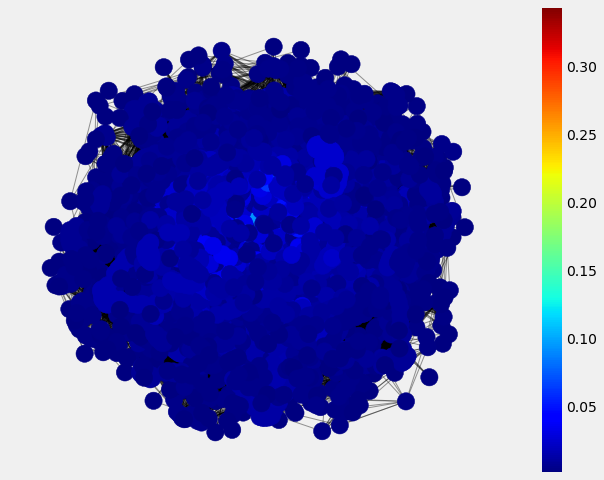

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

pos = nx.spring_layout(g, seed=12345679, k=0.3)
color = list(dict(degreeDict).values())

nx.draw_networkx_edges(g, 
                       pos=pos, 
                       alpha=0.4, 
                       ax=ax)

nodes = nx.draw_networkx_nodes(g, 
                               pos=pos, 
                               node_color=color, 
                               cmap=plt.cm.jet, 
                               ax=ax)

#nx.draw_networkx_labels(g_degreeTop, pos=pos, font_color="black", ax=ax)

plt.axis("off")
plt.colorbar(nodes)
plt.savefig("degree.png", transparent=True, dpi=300)
plt.show()

# Closeness

A closeness centrality é uma métrica que diz o quão próximo um vértice está dos outros nós da rede. Desde já, podemos ver que os Top 10 artistas que obtiveram closeness mais altos, foram os mesmos artistas que apareceram no Top 10 grau de vértices. Mas podemos notar ums diferença quando pintamos os vértices de acordo com a métrica closeness e agora percebemos que há uma maior variação no valores obtidos e por isso vemos as cores no imagem variam mais, principalmente na parte central da imagem.

In [ ]:
closenessDict = nx.closeness_centrality(g)

In [ ]:
closenessArray = []

for key, value in dict(closenessDict).items():
    closenessArray.append([key, value])
closenessDF = pd.DataFrame(closenessArray, columns=["artist_name", "closeness"])

closenessDF = closenessDF.sort_values(by="closeness", ascending=False)
closenessDF.head(10)

,artist_name,closeness
343,Drake,0.586259
205,Rihanna,0.577860
411,The Weeknd,0.558267
430,Kanye West,0.557640
356,Kendrick Lamar,0.554573
910,Coldplay,0.552673
28,Justin Bieber,0.551917
762,Maroon 5,0.546450
212,Ed Sheeran,0.544606
870,The Chainsmokers,0.544514


In [ ]:
closenessTop = list(node for node in closenessDF.head(10)["artist_name"])
g_closenessTop = nx.subgraph(g, closenessTop)

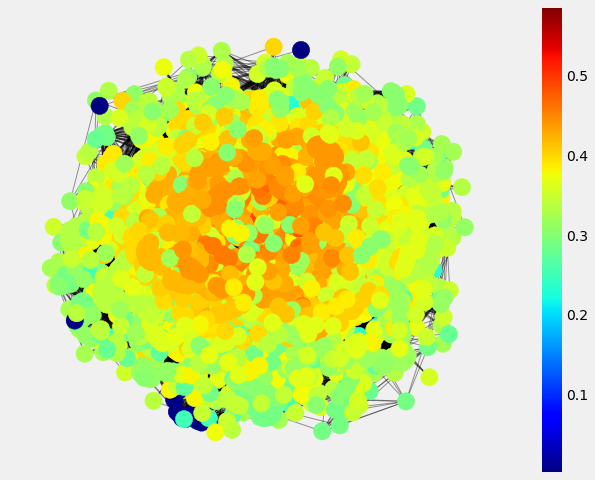

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

pos = nx.spring_layout(g, seed=12345679, k=0.3)
color = list(dict(closenessDict).values())

nx.draw_networkx_edges(g, 
                       pos=pos, 
                       alpha=0.4, 
                       ax=ax)

nodes = nx.draw_networkx_nodes(g, 
                               pos=pos, 
                               node_color=color, 
                               cmap=plt.cm.jet, 
                               ax=ax)

#nx.draw_networkx_labels(g_closenessTop, pos=pos, font_color="black", ax=ax)

plt.axis("off")
plt.colorbar(nodes)
plt.savefig("closeness.png", transparent=True, dpi=300)
plt.show()

# Betweenness

A betweenness centrality mede com que frequência um nó aparece em caminhos mais curtos entre nós em uma rede.

Ao listar o Top 10 vértices com maiores valores para betweenness centrality, ocorreu algo interessante, vemos que os artistas The Chainsmokers, Ed Sheeran e Marron 5 deixaram a lista e os três novos artistas na lista são Outkast, Mariah Carey e Seu Jorge. Isso mesmo, um famoso artista brasileiro está na lista dos vértices mais um certo grau de importância.

Note também, que apesar da imagem para a métrica betweenness centrality ter pouca variação de cor indicando que os valores da métrica variam pouco. Ainda assim, boa parte dos artistas listados nos Top 10 de degree e closeness, aparecem também no Top 10 de betweenness centrality.

In [ ]:
betweennessDict = nx.betweenness_centrality(g)

In [ ]:
betweennessArray = []

for key, value in dict(betweennessDict).items():
    betweennessArray.append([key, value])
betweennessDF = pd.DataFrame(betweennessArray, columns=["artist_name", "betweenness"])

betweennessDF = betweennessDF.sort_values(by="betweenness", ascending=False)
betweennessDF.head(10)

,artist_name,betweenness
205,Rihanna,0.035840
343,Drake,0.027626
28,Justin Bieber,0.018532
356,Kendrick Lamar,0.016114
430,Kanye West,0.015542
910,Coldplay,0.015134
411,The Weeknd,0.014655
8,OutKast,0.013362
134,Mariah Carey,0.013150
2316,Seu Jorge,0.012555


In [ ]:
betweennessTop = list(node for node in betweennessDF.head(10)["artist_name"])
g_betweennessTop = nx.subgraph(g, betweennessTop)

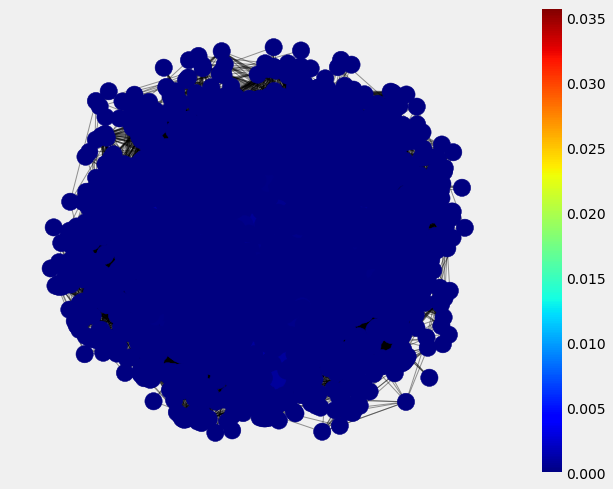

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

pos = nx.spring_layout(g, seed=12345679, k=0.3)
color = list(dict(betweennessDict).values())

nx.draw_networkx_edges(g, 
                       pos=pos, 
                       alpha=0.4, 
                       ax=ax)

nodes = nx.draw_networkx_nodes(g, 
                               pos=pos, 
                               node_color=color, 
                               cmap=plt.cm.jet, 
                               ax=ax)

#nx.draw_networkx_labels(g_betweennessTop, pos=pos, font_color="black", ax=ax)

plt.axis("off")
plt.colorbar(nodes)
plt.savefig("betweenness.png", transparent=True, dpi=300)
plt.show()

# Eigenvector Centrality

Para medir a importância de um vértice baseado em seu vizinhos, temos a métrica da centralidade do autovetor (eigenvector centrality).

Note que, listando o Top 10 artista com maiores valores para essa métrica, agora Coldplay deixou a lista e deu lugar à Major Lazer. Major Lazer é um grupo de música eletrônica que foi criado e ficou bem conhecido na mesma década da coleta dos dados utilizados nesse notebook.

In [ ]:
eigenvectorDict = nx.eigenvector_centrality(g)

In [ ]:
eigenvectorArray = []

for key, value in dict(eigenvectorDict).items():
    eigenvectorArray.append([key, value])
eigenvectorDF = pd.DataFrame(eigenvectorArray, columns=["artist_name", "eigenvector"])

eigenvectorDF = eigenvectorDF.sort_values(by="eigenvector", ascending=False)
eigenvectorDF.head(10)

,artist_name,eigenvector
343,Drake,0.081141
205,Rihanna,0.079989
411,The Weeknd,0.073714
430,Kanye West,0.073072
762,Maroon 5,0.069068
212,Ed Sheeran,0.068685
870,The Chainsmokers,0.068683
414,Major Lazer,0.067675
28,Justin Bieber,0.067547
356,Kendrick Lamar,0.067043


In [ ]:
eigenvectorTop = list(node for node in eigenvectorDF.head(10)["artist_name"])
g_eigenvectorTop = nx.subgraph(g, eigenvectorTop)

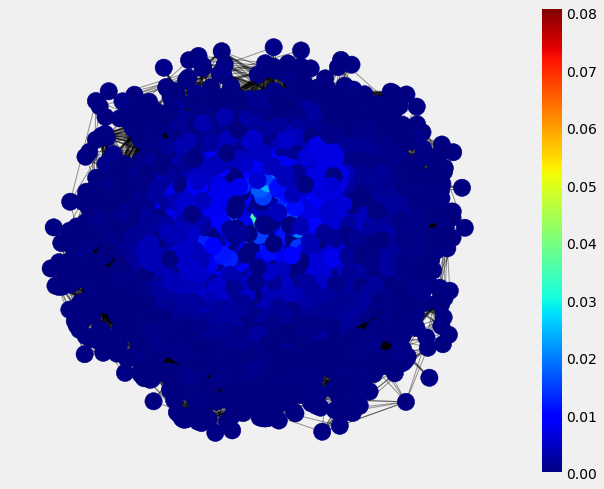

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

pos = nx.spring_layout(g, seed=12345679, k=0.3)
color = list(dict(eigenvectorDict).values())

nx.draw_networkx_edges(g, 
                       pos=pos, 
                       alpha=0.4, 
                       ax=ax)

nodes = nx.draw_networkx_nodes(g, 
                               pos=pos, 
                               node_color=color, 
                               cmap=plt.cm.jet, 
                               ax=ax)

#nx.draw_networkx_labels(g_eigenvectorTop, pos=pos, font_color="black", ax=ax)

plt.axis("off")
plt.colorbar(nodes)
plt.savefig("betweenness.png", transparent=True, dpi=300)
plt.show()

# Análise Bivariada

Como mencionado anteriormente, na seção Degree Centrality, aqui veremos como a rede em geral se comporta em relação ao grau dos vértices. Podemos perceber facilmente, que grande parte da rede possui vértices com grau menor que 1000 e todos os vértices listados no Top 10 para a métrica degree centrality podem ser considerados outliers.

In [ ]:
degree_sequence = sorted([d for n, d in g.degree()], reverse=True)

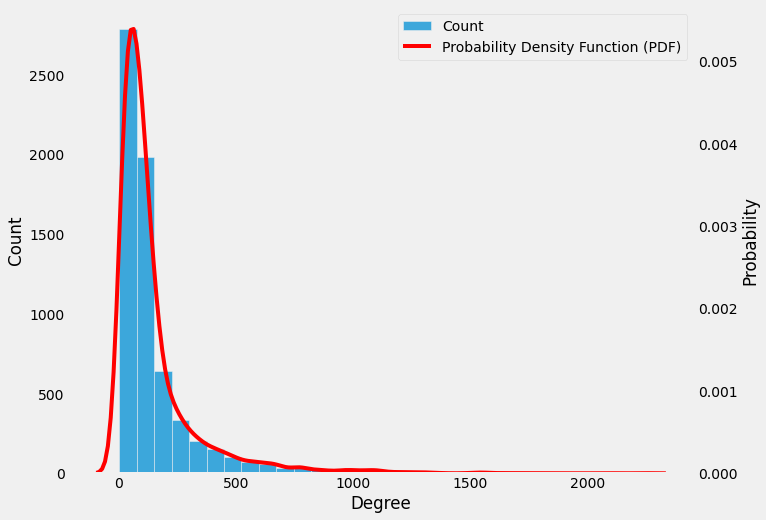

In [ ]:
plt.style.use("fivethirtyeight")
#plt.style.use("default")

fig, ax = plt.subplots(1,1,figsize=(10,8))

sns.histplot(degree_sequence,bins=30,label="Count",ax=ax)
ax2 = ax.twinx()
sns.kdeplot(degree_sequence,color='r',label="Probability Density Function (PDF)",ax=ax2)

# ask matplotlib for the plotted objects and their labels
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax.grid(False)
ax2.grid(False)
ax.set_xlabel("Degree")
ax2.set_ylabel("Probability")

plt.savefig('probability_density_function.png', transparent=True,dpi=600,bbox_inches="tight")
plt.show()

# Análise Multivariada

In [ ]:
bc = pd.Series(betweennessDict)
dc = pd.Series(degreeDict)
ec = pd.Series(eigenvectorDict)
cc = pd.Series(closenessDict)

df = pd.DataFrame.from_dict({"Betweenness": bc,
                            "Degree": dc,
                            "EigenVector": ec,
                            "Closeness": cc})
df.reset_index(inplace=True,drop=True)
df.head()

,Betweenness,Degree,EigenVector,Closeness
0,0.001382,0.115668,0.041591,0.494986
1,0.000927,0.117665,0.047295,0.495822
2,0.004907,0.203533,0.063870,0.533398
3,0.002626,0.152074,0.054381,0.520578
4,0.000935,0.123041,0.048393,0.496777


Na imagem abaixo, é possível observar um fato curioso. Observe que para métricas Degree, Closeness e Eigenvector, nos gráficos que dispõem os nós combinando essas métricas há proporcionalidade, ou seja, conforme o valor de uma métrica cresce o valor da outra métrica também cresce. Note também, que a métrica de centralidade Betweenness não apresenta nenhuma proporcionalidade quando combinada com outra métrica.

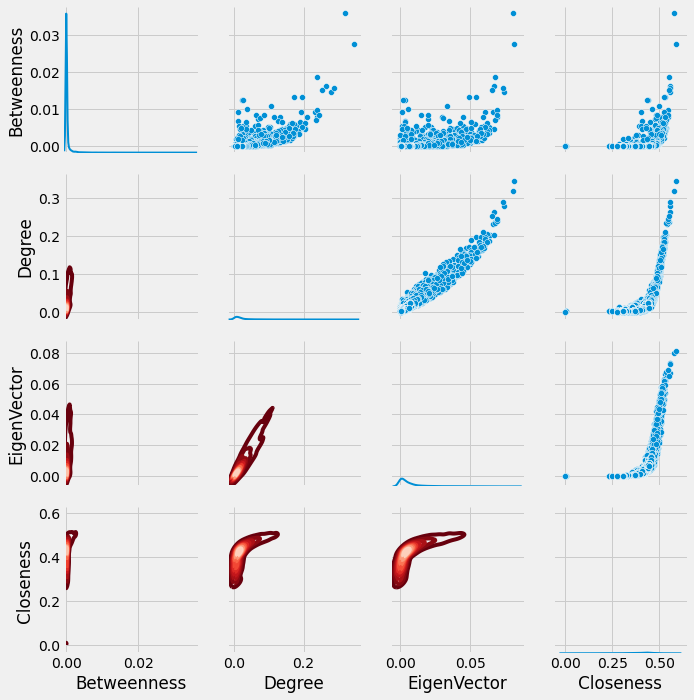

In [ ]:
fig = sns.PairGrid(df)
fig.map_upper(sns.scatterplot)
fig.map_lower(sns.kdeplot, cmap="Reds_r")
fig.map_diag(sns.kdeplot, lw=2, legend=False)

plt.savefig('multi.png', transparent=True,dpi=800,bbox_inches="tight")
plt.show()

# Análise de Decomposição

Como o core de uma rede, por consequência, é o conjunto de vértices com o maior número de vizinhos da rede é esperado que esse conjunto também tenha vértices considerados importantes. É exatamente isso que vemos no core da nossa rede, onde todos os vértices listados no Top 10 de cada métrica estão contidos no core da rede que estamos estudando.

In [ ]:
set([v for k,v in nx.core_number(g).items()])

{2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177}

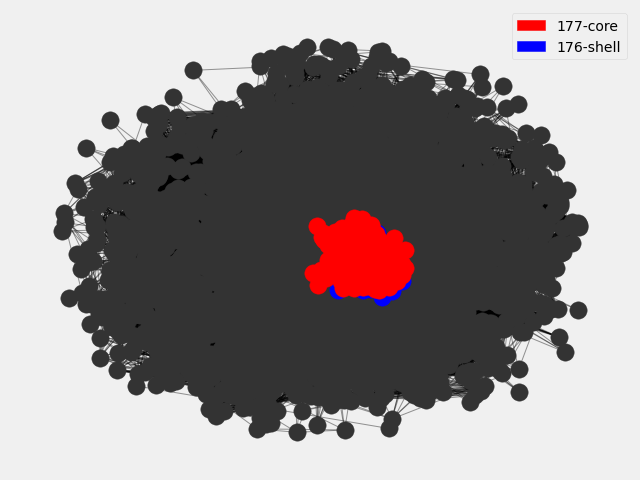

In [ ]:
# the degree of network(g)
fig, ax = plt.subplots(1,1,figsize=(10,8))

# Find k-cores
g_core_176 = nx.k_shell(g, 176)
g_core_177 = nx.k_core(g, 177)

# layout position
pos = nx.spring_layout(g,seed=123456789,k=0.3)

# draw edges
nx.draw_networkx_edges(g,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(g,
                 pos=pos,
                 node_color="#333333")

# draw nodes
nodes = nx.draw_networkx_nodes(g_core_176,
                 pos=pos,
                 node_color="blue")

nodes = nx.draw_networkx_nodes(g_core_177,
                 pos=pos,
                 node_color="red")

# static legend
red_patch = mpatches.Patch(color='red', label='177-core')
blue_patch = mpatches.Patch(color='blue', label='176-shell')
plt.legend(handles=[red_patch,blue_patch])

plt.axis("off")
plt.savefig('k-core.png', transparent=True,dpi=600)
plt.show()

In [ ]:
nx.write_graphml(g, "spotify_network.graphml")

In [ ]:
list(g_core_176)

['AC/DC',
 'Aerosmith',
 'Bubba Sparxxx',
 'Rick Ross',
 "Lil' Kim",
 'Yellowcard',
 'Harry Styles',
 'Bill Withers',
 'Huey',
 'Vanilla Ice',
 'Dem Franchize Boyz',
 'Buckcherry',
 'Shop Boyz',
 'Maejor Ali',
 'Juelz Santana',
 'OG Maco',
 "Plain White T's",
 'Jidenna',
 'Yung Joc',
 'Jonas Brothers',
 'POWERS',
 'Martin Solveig',
 'Lost Kings',
 'Hollywood Undead',
 'Spice Girls',
 'Selena Gomez & The Scene']

In [ ]:
list(g_core_177)

['Enrique Iglesias',
 'A$AP Rocky',
 'Kesha',
 'Shania Twain',
 'Sam Hunt',
 '2Pac',
 'ayokay',
 'Passenger',
 'Kent Jones',
 'Martin Jensen',
 'OMI',
 'MKTO',
 'T-Wayne',
 'John Mayer',
 'Maroon 5',
 'OutKast',
 'Grits',
 'Flo Rida',
 'Dillon Francis',
 'Afroman',
 'Jay Sean',
 'Andrew McMahon in the Wilderness',
 'Kid Ink',
 'Rudimental',
 'The Chainsmokers',
 'Trey Songz',
 'Justin Bieber',
 'Cobra Starship',
 'Gotye',
 'Tove Lo',
 'The Goo Goo Dolls',
 'Fetty Wap',
 'Brett Eldredge',
 'R. Kelly',
 'Ginuwine',
 'Starley',
 'Wes Walker',
 'Snakehips',
 'Timbaland',
 'Sigala',
 'blackbear',
 'V.I.C.',
 'Miley Cyrus',
 'Missy Elliott',
 'Zedd',
 'Sean Paul',
 'Post Malone',
 'Martin Garrix',
 'Michael Jackson',
 'Travis Scott',
 'Foster The People',
 'Juvenile',
 'Daryl Hall & John Oates',
 '3 Doors Down',
 'Terror Jr',
 'Luke Bryan',
 'Benny Benassi',
 'Lauv',
 'Rascal Flatts',
 'Kevin Gates',
 'Survivor',
 'The Band Perry',
 'Charli XCX',
 'Tori Kelly',
 'P!nk',
 'Gym Class Heroes',
